<a href="https://colab.research.google.com/github/MamadouBousso/Pytorch_courses/blob/main/ClassificationSimplePartie1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Classification simple avec pytorch

### Objectif:
* construire un modèle de classification binaire
* comprendre le concept de logits et son lien avec les probabilités
* utiliser la fonction crossentropy pour entrainer un modèle
* utiliser la fonction loss pour gérer les ensembles de données déséquilibrés
* comprendre les concepts de decision boundary et de séparabilité
* apprendre comment le choix d'un seuil de classification impacte les métriques d'évaluation
* construire des courbes ROC et précision-rappel

#### Importons toutes les bibliothéques nécessaires

In [1]:
import numpy as np
import torch
import torch.optim as optim
import torch.nn as nn
import torch.functional as F
from torch.utils.data import TensorDataset, DataLoader
from torch.utils.tensorboard import SummaryWriter

from sklearn.datasets import make_moons
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, roc_curve, precision_recall_curve, auc, ConfusionMatrixDisplay

import matplotlib.pyplot as plt
import seaborn as sns


#### Remarques
Dans un modèle de classification, la sortie est la
probabilité prédite pour qu'une  classe soit positive. Dans notre cas, le modèle
prédira la probabilité qu'un point soit bleu.
Le choix de la classe positive ou négative 
n'affecte pas les performances du modèle. 

### Generation des données
Nous allons considerer deux fonctionnalités **x1** et **x2**. Nous utiliserons le package **make_moons** de **Scikit-Learn** pour générer un ensemble de 100 points de données synthetiques. Nous allons également ajouter du bruit gaussien et définir un seed aléatoire pour garantir la
reproductibilité.

In [2]:
X,y = make_moons(n_samples = 100, noise = 0.3, random_state = 0)

#### Split
C'est la premiére chose à faire. On va utiliser la fonction **train_test_split()** de scikit-learn

In [3]:
X_train,X_val,y_train,y_val = train_test_split(X,y,test_size = .2,random_state = 13)

#### Normalisation
N'oubliez pas que vous ne devez utiliser que les données de train pour la normalisation. On peut utiliser 
StandardScaler de scikit-learn et appliquer sa méthode **transform()** pour appliquer les
étapes de prétraitement à tous les ensembles de données : training, validation et test.


In [4]:
sc = StandardScaler()
sc.fit(X_train)
X_train = sc.transform(X_train)
X_val = sc.transform(X_val)

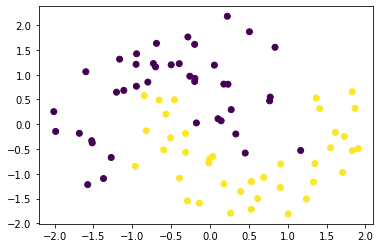

In [5]:
plt.scatter(X_train[:,0],X_train[:,1],c=y_train)

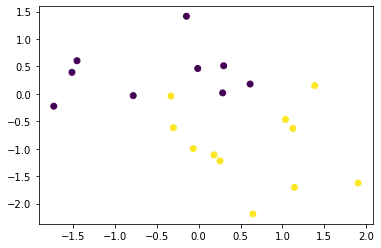

In [6]:
plt.scatter(X_val[:,0],X_val[:,1],c=y_val)

### Preparation des données
Nous l'avons deja mis en pratique dans le notebook précédent

In [7]:
torch.manual_seed(13)
# Creation des tenseurs de train
x_tensor_train = torch.as_tensor(X_train).float()
y_tensor_train = torch.as_tensor(y_train.reshape(-1,1)).float()
# Creation des tenseurs de validation
x_tensor_val = torch.as_tensor(X_val).float()
y_tensor_val = torch.as_tensor(y_val.reshape(-1,1)).float()
# Creation des dataset
train_ds = TensorDataset(x_tensor_train,y_tensor_train)
val_ds = TensorDataset(x_tensor_val,y_tensor_val)
# Creation des dataloader
train_dl = DataLoader(dataset = train_ds, batch_size = 16, shuffle = True)
val_dl = DataLoader(dataset = val_ds, batch_size = 16, shuffle = True)

### Modéle
Si nous essayons d'assigner un modéle de regression linéaire à notre probléme de classification, cela na marchera pas car les labels sont discrets. Nous allons assigner un nouveau modéle mathématique:
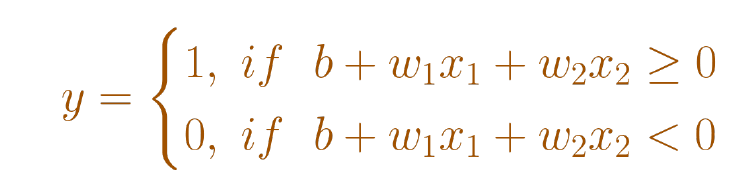

La valeur **1** correspond à la classe positive et la valeur **0** equivaut à la classe négative.

Mais au lieu d'assigner les valeurs 0 ou 1 à une image, on va calculer la probabilité pour que y soit de classe **1** ou **0**. L'idée est de calculer $$ z = b + w_1x_1 + w_2x_2$$ et d'evaluer la probabilité pour que $$ z = 1 $$ ou $$ z=0 $$. **z** est appelée logit.

Notre raisonnement consistera à assigner aux grandes valeurs logit positives des probabilités plus élevées d'être dans la classe positive,  aux grandes valeurs logit négatives
des probabilités plus faibles d'être dans la classe positive.
Pour de très grandes valeurs logit positives et négatives (z), nous aimerions avoir :
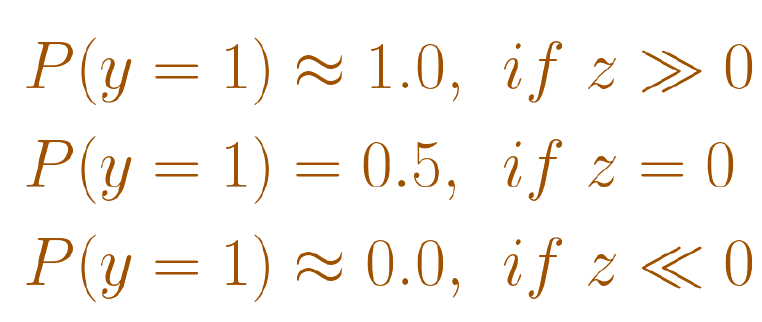



**Probléme: Trouver une fonction bijective qui à chaque valeur z  associe une probabilité ?**

Pour cela considérons la fonction $$ ratioprob(p) = p/q $$ avec p la probabilité pour qu'un evenement survienne et q la probabilité pour que l'evement contraire survienne. Elle permet d'evaluer les chances pour qu'un evenement se produise. 

Par exemple Imaginons que nous parions sur le vainqueur de la finale d'un tournoi avec deux equipes en lice: A et B. L'equipe A est  favorite et a  75 % de chances de gagner. Alors,
L'equipe B n'a que 25 % de chances de gagner. Si vous pariez sur l'equipe A, vos chances
de gagner sont de 3 contre 1 (75 contre 25). Si vous misez sur l'equipe B, vos chances de gagner,  sont de 1 à 3 (25 à 75), ou de 0,33 à 1.

Nous allons l'implementer et la visualiser

In [8]:
def ratio_prob(p):
  return p/(1-p)

(ratio_prob(0.3),ratio_prob(0.7))

(0.4285714285714286, 2.333333333333333)

In [9]:
x = np.linspace(0.0,1.0,200)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in true_divide
  


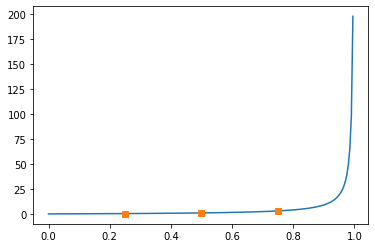

In [10]:

plt.plot(x,ratio_prob(x))
x0 = [0.25,0.5,0.75]
y0 = [ratio_prob(0.25),ratio_prob(0.5),ratio_prob(0.75)]
plt.plot(x0, y0, "s")

Cette fonction n'est pas symetrique. Par contre son logarithme est une fonction symetrique et parcourt l'ensemble des réels.

La symétrie nous garantit que différents choix de la classe positive donneront le même modéle. 

Exemple: Dire que la classe des points mauves ou des points jaunes est la classe positive revient au même avec la fonction symétrique

In [11]:
def log_ratio_prob(p):
  return np.log(p/(1-p))
(log_ratio_prob(0.3),log_ratio_prob(0.7))

(-0.8472978603872036, 0.8472978603872034)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in true_divide
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in log
  


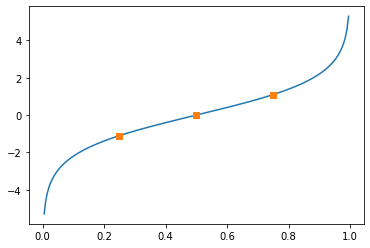

In [12]:
plt.plot(x,log_ratio_prob(x))
x0 = [0.25,0.5,0.75]
y0 = [log_ratio_prob(0.25),log_ratio_prob(0.5),log_ratio_prob(0.75)]
plt.plot(x0, y0, "s")

Posons $ z = log(p/(1-p)) $

donc $ exp(z) = p/(1-p) $

$ exp(z) - p * exp(z) = p $

$ p * (1 +  exp(z)) = exp(z) $

$ p = exp(z) /(1 + exp(z)) $

On peut le recrire sous la forme:

$ p = 1 /(1 + exp(-z)) $

Ce qui correspond à la fonction sigmoid qui permet d'associer à chaque valeur de z une probabilité unique p. Nous obtenons:

$$ z = b + w_1x_1 + w_2x_2$$

et $$ p  = sigmoid(z) = 1/(1 + exp(-z))$$

In [13]:
def sigmoid(z):
  return 1/(1 + np.exp(-z))

p = 0.75

(sigmoid(log_ratio_prob(p)),sigmoid(log_ratio_prob(1 - p)))

(0.75, 0.25)

##### Sous pytorch vous avez deux fonctions sigmoid:
* Une fonction torch.sigmoid qui est une fonction qui prend en entrée un tenseur et retourne un tenseur

* Une classe nn.sigmoid qui est un modéle qui hérite de nn.Module et qui implemente une fonction forward. Elle peut etre utilisée comme couche d'un autre modele.


In [14]:
torch.sigmoid(torch.tensor(1.096))

tensor(0.7495)

### Regression logistique

Étant donné deux caractéristiques, x1 et x2, le modèle ajustera une régression linéaire telles que
les sorties sont des logits (z), qui sont convertis en probabilités à l'aide d'une fonction sigmoïd.

$$ P(y = 1) = \sigma(z) = \sigma(b + w_1x_1 + w_2x_2) $$

En terme de reseau de neurones cela donnera le schéma ci-dessous:

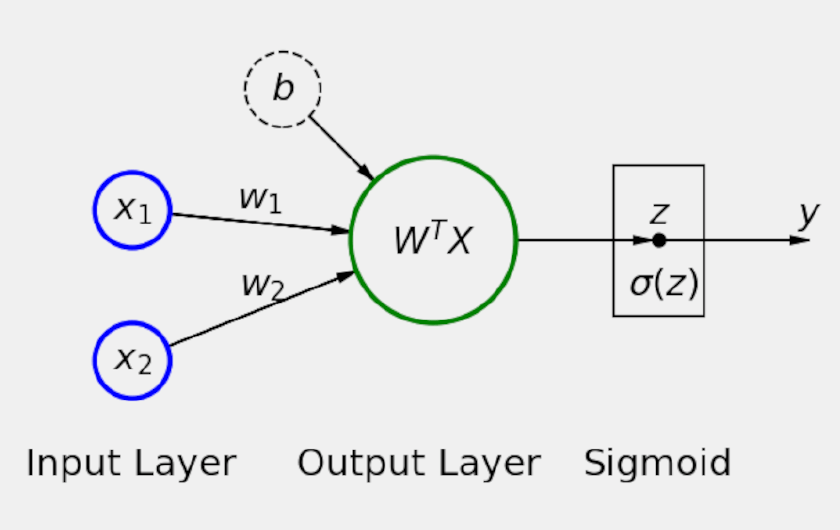

Nous pouvons considérer la régression logistique comme le deuxième réseau de neurones le plus simple
possible. C'est à peu près la même chose que la régression linéaire, mais avec une fonction sigmoïd
appliquée aux résultats de la couche de sortie (z).

Exercice:

Creer le reseau en utilisant nn.Sequential, nn.Linear et nn.Sigmoid

In [15]:
torch.manual_seed(43)
logisticR = nn.Sequential()
logisticR.add_module("linear",nn.Linear(2,1))
logisticR.add_module("sigmoid",nn.Sigmoid())
print(logisticR.state_dict())

OrderedDict([('linear.weight', tensor([[-0.0651, -0.4292]])), ('linear.bias', tensor([0.5954]))])


### Fonction perte

#### BCE: l'entropie croisée binaire

La perte BCE nécessite les probabilités prédites, telles que renvoyées par la fonction sigmoïd, et les vraies label (y) pour son calcul. Pour chaque point i de données  dans l'
ensemble d'apprentissage, il commence par calculer l'erreur correspondant à la vraie valeur du point à
classer.

Si le point  appartient à la classe positive (y=1), nous aimerions que notre modèle
prédise une probabilité proche de 1.  Un 1 parfait se traduirait par le
logarithme de un, qui vaut zéro. Ca a du sens; une prédiction parfaite signifie zéro
perte:
$$ y_i = 1 => erreur_i = log(P(y_i = 1)) $$



Que se passe-t-il si le point i de données appartient à la classe négative (y=0) ? On ne peut alors simplement
utiliser la probabilité prédite parce que le modèle produit la probabilité
d'un point appartenant à la classe positive et non à la classe négative. 

Heureusement, ce dernier peut être
calcule facilement :

$$ y_i = 0 => erreur_i = log(1 - P(y_i = 1)) $$

Une fois toutes les erreurs calculées, elles sont agrégées en une fonction perte. Pour la
perte d'entropie croisée binaire, nous prenons simplement la moyenne des erreurs et inversons son signe.

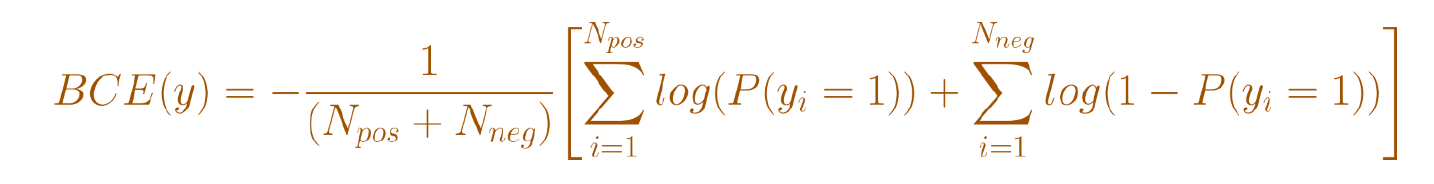

In [16]:
# Exemple
labels = torch.tensor([1.0,0.0])
preds = torch.tensor([0.9,0.2])

erreur_pos = preds[labels == 1.0]
print(erreur_pos)

first_summation = torch.log(erreur_pos).sum()

erreur_neg = preds[labels == 0.0]

second_summation = torch.log(1 - erreur_neg).sum()

n_total = labels.size(0)

loss = - (first_summation + second_summation)/n_total

print(loss)

tensor([0.9000])
tensor(0.1643)


Mais en general voici la formule adoptée pour le BCE:

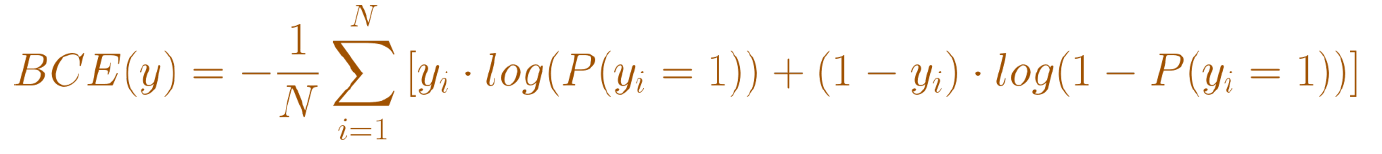

In [17]:
summation = -(1/n_total) * (labels * torch.log(preds) + (1 - labels)*torch.log(1- preds)).sum()

In [18]:
summation

tensor(0.1643)

[Lien pour mieux comprendre le BCE](https://towardsdatascience.com/understanding-binary-cross-entropy-log-loss-a-visual-explanation-a3ac6025181a)


##### Pytorch et BCELoss

Effectivement, PyTorch implémente la perte d'entropie croisée binaire, nn.BCEloss. Juste
comme son homologue de régression, MSELoss, présenté dans la premiére partie du cours, il s'agit d'une fonction d'ordre supérieur
 qui renvoie la fonction de perte réelle.
La fonction d'ordre supérieur BCELoss prend deux arguments optionnels  :
* **reduction** : elle prend soit **mean**, soit **sum**, soit **none**. Le paramétre **mean**   par défaut correspond à la derniére version du BCE définie ci-dessus. **sum** renverra la somme des erreurs, au lieu de la moyenne. La dernière option, **none**, correspond à la version non réduite des valeurs, c'est-à-dire qu'il renvoie le tableau complet des erreurs.

* **weight** : la valeur par défaut est **none**, ce qui signifie que chaque point de données a le même poids. Si
renseigné, il doit s'agir d'un tenseur de taille égale au nombre d'éléments dans
un mini-lot, représentant les poids attribués à chaque élément du lot.
En d'autres termes, cet argument vous permet d'attribuer des poids différents à chaque
élément du lot en cours, en fonction de sa position. Elle est utilisée pour des notions avancées.

**Elle retourne une nouvelle fonction qui prend en paramétres les predictions d'abord puis les vrais labels apres.**
Attention: Il faut respecter cet ordre

In [19]:
loss_fn = nn.BCELoss()
loss_fn

BCELoss()

In [20]:
loss = loss_fn(preds, labels)
print(loss.item())

# Mauvais 
bad_loss = loss_fn(labels, preds)
print(bad_loss.item())

0.16425204277038574
15.000000953674316


##### Autre version: **BCEWithLogitLoss**
BCELoss prenait des probabilités comme argument (avec les
étiquettes, évidemment). Cette fonction de perte prend les logits comme argument, au lieu des
probabilités.

Cela signifie que vous ne devez PAS ajouter un modele sigmoïd comme dernière couche de votre modèle lors de l'utilisation de
cette fonction de perte. Cette perte combine à la fois la couche sigmoïde et le
perte d'entropie croisée en un seul.
Vous avez deux options:
* Option 1 : **nn.Sigmoïd** comme dernière couche, ce qui signifie que votre modèle produit des probabilités, combinées avec la fonction **nn.BCEloss**

* Option 2 : pas de sigmoïd dans la dernière couche, ce qui signifie que votre modèle
produit des logits, combinés avec la fonction **nn.BCEWithLogitsLoss**.

* Attention: Ne Mélangez pas **nn.Sigmoid** et **nn.BCEWithLogitsLoss**.


De plus, l'option 2 est préférée car elle est numériquement plus stable que l'option 1.

##### Pytorch et BCEWithLogitsLoss


La fonction d'ordre supérieur BCELossWithLogits prend trois arguments optionnels  :
* **reduction** : elle prend soit **mean**, soit **sum**, soit **none**. Le paramétre **mean**   par défaut correspond à la derniére version du BCE définie ci-dessus. **sum** renverra la somme des erreurs, au lieu de la moyenne. La dernière option, **none**, correspond à la version non réduite des valeurs, c'est-à-dire qu'il renvoie le tableau complet des erreurs.

* **weight** : la valeur par défaut est **none**, ce qui signifie que chaque point de données a le même poids. Si
renseigné, il doit s'agir d'un tenseur de taille égale au nombre d'éléments dans
un mini-lot, représentant les poids attribués à chaque élément du lot.
En d'autres termes, cet argument vous permet d'attribuer des poids différents à chaque
élément du lot en cours, en fonction de sa position. Elle est utilisée pour des notions avancées.

* **pos_weight**: le poids des échantillons positifs, il doit s'agir d'un tenseur de longueur
est égal au nombre de labels associées à un point de données. Par exemple dans notre probléme nous avons un seul label par donnée et il est binaire. Ne le confondez pas avec le nombre classe qu'on peut associer à une donnée.

In [21]:
loss_fn_logits = nn.BCEWithLogitsLoss()
loss_fn_logits

BCEWithLogitsLoss()

In [22]:
logit1 = log_ratio_prob(0.9)
logit2 = log_ratio_prob(0.2)
logits = torch.tensor([logit1,logit2])

l = loss_fn_logits(logits,labels)
print(l)

tensor(0.1643)


#### Données déséquilibrées
Quand les données provenant d'une classe sont plus nombreuses que celle provenant d'une autre classe, on parle de données déséquilibrées.

Augmentons les données de la classe négative dans l'exemple précédent. 

In [23]:
labels_imb = torch.tensor([1.0,0.0,0.0,0.0])
logits_imb = torch.tensor([logit1,logit2,logit2,logit2])
loss  = loss_fn_logits(logits_imb,labels_imb)
print(loss)

tensor(0.1937)


De toute évidence, il s'agit d'un ensemble de données déséquilibré. Il y a trois fois plus de points de données dans
la classe négative que dans la classe positive. Pour compenser le déséquilibre, on peut affecter à
l'argument pos_weight
 de **BCEWithLogitsLoss** une valeur égale au rapport des exemples négatifs sur les exemples positifs:

$$ pos\_weight = \frac{nombre \ de \ labels \ de \ classe \ negative }{nombre \ de \ labels \ de \ classe \ positive} $$

Dans le cas de notre exemple pos_weight sera un tenseur de longueur 1 car il y a un seul label pour chaque point.




In [24]:
n_neg = (labels_imb == 0.0).sum().float()

n_pos = (labels_imb == 1.0).sum().float()

pos_weight = (n_neg / n_pos).view(1,)
print(pos_weight)

tensor([3.])


In [25]:
loss_fn_bal = nn.BCEWithLogitsLoss(pos_weight = pos_weight)

In [26]:
loss_b = loss_fn_bal(logits_imb,labels_imb)
print(loss_b)

tensor(0.2464)


En fait pytorch calcule le loss suivant:

$$ BCEWithLogitsLoss = \frac{ pos\_weight.\sum_{i=1}^{N_{pos}} loss_i + \sum_{i=1}^{N_{neg}} loss_i}{N_{pos} + N_{neg}} $$

## Training

On va utiliser la classe StepByStep conçue lors du cours sur la regression linéaire

In [27]:
from torch.nn.modules.loss import BCEWithLogitsLoss
# Configuratin du modele

torch.manual_seed(13)
lr = 0.01

model = nn.Sequential()

model.add_module('linear',nn.Linear(2,1))

optimiseur = optim.SGD(model.parameters(),lr = lr)

loss_fn = BCEWithLogitsLoss()





In [28]:
class StepByStep(object):
  """
  Cette classe permet de faire le training du modele
  """
  def __init__(self, model, optimiseur,loss_fn):
    """Doit être initialisé avec les arguments necessaires eu training 
    à savoir: le modele, l'optimiseur et la fonction perte.
    Nous aurons besoins de lui passer les loaders de données et le writer pour interfacer avec Tensorboard

    Nous devons à nouveau ajouter le code suivant à la méthode du constructeur (comme
    nous avons fait avec les loaders)
    """
    self.model = model
    self.optimiseur = optimiseur
    self.loss_fn = loss_fn

    # Attribuer le device au model
    self.device = 'cuda' if torch.cuda.is_available() else 'cpu'

    self.model.to(self.device)
    # Les loaders 
    self.train_dl = None
    self.val_dl = None
    self.writer =  None

    # Les variables
    self.epochs = 0
    
    self.loss = []
    self.val_loss = []
    # Fonctions permettant de faire le train

    self.train_step = self._make_train_step()
    self.val_step = self._make_eval_step()

  def to(self,device):
    """
    Permet de changer le device du model
    """
    self.device  = device
    self.model.to(self.device)

  def set_loaders(self,train_dl,val_dl = None):
    """
    Permet de modifier les dataloaders
    """
    self.train_dl = train_dl
    self.val_dl = val_dl

  def set_tensorboard(self,name,folder = 'runs'):
    """
    Permet de creer un SummaryWriter qui interface avec le tensorboard
    """
    suffix = datetime.datetime.now().strftime('%Y%m%d%H%M%S')
    self.writer = SummaryWriter('{}/{}_{}'.format(folder, name, suffix))

  def _make_train_step(self):
    def training_model_pas(X,y):
    
      # Attention: permet juste de mettre le modéle en mode training et non en mode evalation. Par exemple le dropout n'est fait que durant 
      # le training
      self.model.train()

      # On n'appelle pas la methode froward() mais juste le modele
      y_hat_tens = self.model(X)
  

      
      loss_tens = self.loss_fn(y_hat_tens , y)

  

      loss_tens.backward()
  
      self.optimiseur.step()

  

    
      self.optimiseur.zero_grad()

      return loss_tens.tolist()

  
    
    return training_model_pas

  def _make_eval_step(self):
    def training_model_eval_pas(X,y):
    
      # Attention: permet juste de mettre le modéle en mode training et non en mode evalation. Par exemple le dropout n'est fait que durant 
      # le training
      self.model.eval()

      # On n'appelle pas la methode froward() mais juste le modele
      y_hat_tens = self.model(X)
  

    

      loss_tens = self.loss_fn(y_hat_tens , y)

  

      return loss_tens.tolist()

  
    
    return training_model_eval_pas

  def _mini_batch(self,validation = None):
    if validation != None:
      step = self.val_step
      loader = self.val_dl
    
    else:
      step = self.train_step
      loader = self.train_dl
    
    if loader is None:
      return None
  
    mini_batch_loss = []
    for x,y in loader:
      x = x.to(self.device)
      y = y.to(self.device)
      batch_loss = step(x,y)
      mini_batch_loss.append(batch_loss)
    return np.mean(mini_batch_loss)

  def train(self,n_epochs, seed = 42):
  
    torch.manual_seed(seed)

    #model = nn.Sequential(nn.Linear(1,1)).to(device)
    self.writer = SummaryWriter()
  
    for i in range(n_epochs):
  
      self.epochs += 1
      
      #print('ici')
      erreur_train = self._mini_batch()
      
      self.loss.append(erreur_train)
      
      with torch.no_grad():

        erreur_val = self._mini_batch(validation = True)

        self.val_loss.append(erreur_val)
        #print(erreur_train)
      if self.writer:
        scalars = {'training': erreur_train}
        if erreur_val is not None:
          scalars.update({'validation': erreur_val})
      # Records both losses for each epoch under tag "loss"
        self.writer.add_scalars(main_tag='loss', tag_scalar_dict=scalars,global_step=i)
  
    if self.writer:
    # Flushes the writer
      self.writer.flush()

  def save_checkpoint(self,nom_fichier):
    """Permet de sauver le modele"""
    checkpoint = {
    'epoch':self.epochs,
    'model.state_dict': self.model.state_dict(),
    'optimiser.state_dict': self.optimiseur.state_dict(),
    'loss': self.loss,
    'val_loss':self.val_loss
    }
    torch.save(checkpoint,nom_fichier)

  def load_checkpoint(self, nom_fichier):
    """Permet de restaurer le modele"""
    checkpoint = torch.load(nom_fichier)
    self.model.load_state_dict(checkpoint['model.state_dict'])
    self.optimiseur.load_state_dict(checkpoint['optimiser.state_dict'])
    self.epochs = checkpoint['epoch']
    saved_loss = checkpoint['loss']
    saved_val_loss = checkpoint['val_loss']
    # Ne pas oublier de mettre le modele en mode train
    self.model.train()

  def make_prediction(self,x):
    """Faire une prediction à partir d'un tableau numpy"""
    # Mettre le modele en mode prediction
    self.model.eval()

    x_tensor = torch.as_tensor(x).float()

    y_hat = self.model(x_tensor.to(self.device))

    # Ramener le modele en training mode
    self.model.train()
    # Retourner sous forme de tableau numpy
    return y_hat.detach().cpu().numpy()

  def plot_losses(self):
    fig = plt.figure(figsize=(10, 4))
    plt.plot(self.loss, label='Training Loss', c='b')
    if self.val_dl:
      plt.plot(self.val_loss, label='Validation Loss', c='r')
    plt.yscale('log')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.tight_layout()
    return fig

  def add_graph(self):
    if self.train_loader and self.writer:
      # Extraire un seul mini-batch et utiliser add_graph du writer
      x_dummy, y_dummy = next(iter(self.train_loader))
      self.writer.add_graph(self.model, x_dummy.to(self.device))




In [29]:
# Training du modele

n_epochs = 1000

sbs = StepByStep(model,  optimiseur,loss_fn)
sbs.set_loaders(train_dl, val_dl)
sbs.train(n_epochs)

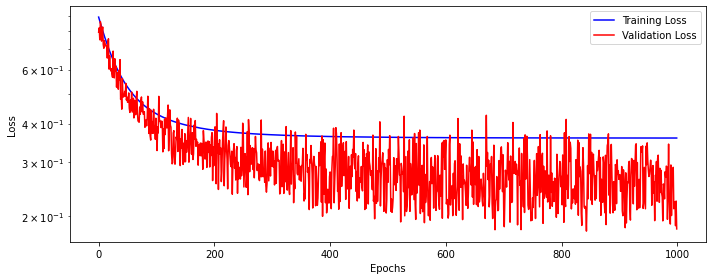

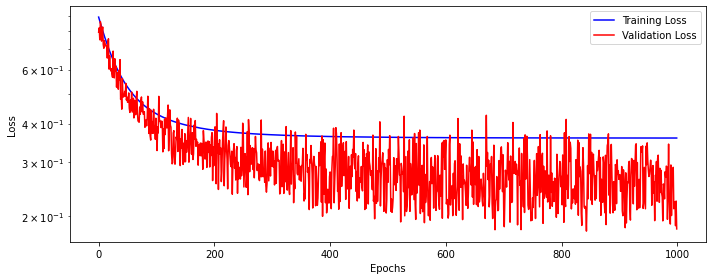

In [30]:
sbs.plot_losses()

* Remarque: La courde de validation se comporte mieux que la courbe bleue.
Ceci est dû au fait que les données de validation sont plus simples à classifier que les données de train( Voir courbe au-dessus).

In [31]:
print(sbs.model.state_dict())

OrderedDict([('linear.weight', tensor([[ 1.1810, -1.8738]])), ('linear.bias', tensor([-0.0599]))])


* Le modele produit des logits donc nous pouvons reconstruire l'equation correspondante:

$$ z = -0.0599 + 1.1810*x_1 - 1.8738*x_2 $$

In [32]:
# Faisons un peu de prédiction 
preds = sbs.make_prediction(x_tensor_train[:4])
print(preds)
# Ces predictions sont des logits, on peut les transformer en probabilités en utilisant le sigmoid
print(sigmoid(preds))

[[ 0.20481284]
 [ 2.9500349 ]
 [ 3.6984124 ]
 [-1.2332629 ]]
[[0.551025  ]
 [0.9502651 ]
 [0.9758356 ]
 [0.22561087]]


* Le point où le logit vaut 0 determine la decision boundary

* Rappelons que nous avons un seuil egal à 0.5 et que si la probabilité est supérieure à 0.5 alors y = 1 et 0 sinon.

* Mais comme nous utilisons une fonction sigmoid qui vaut 0.5 quand le logit vaut 0, nous pouvons classifier en comparant le logit avec 0.

* On peut faire varier le seuil

In [33]:
classes = (preds >= 0).astype(int)
print(classes)

[[1]
 [1]
 [1]
 [0]]


## Decision boundary
Pour chaque point $$x_1$$ nous pouvons determiner un point $$x_2$$ pour lequel le logit est nul. Cet ensemble forme une droite qu'on appelle decision boundary dans le cadre de la regression logistique.
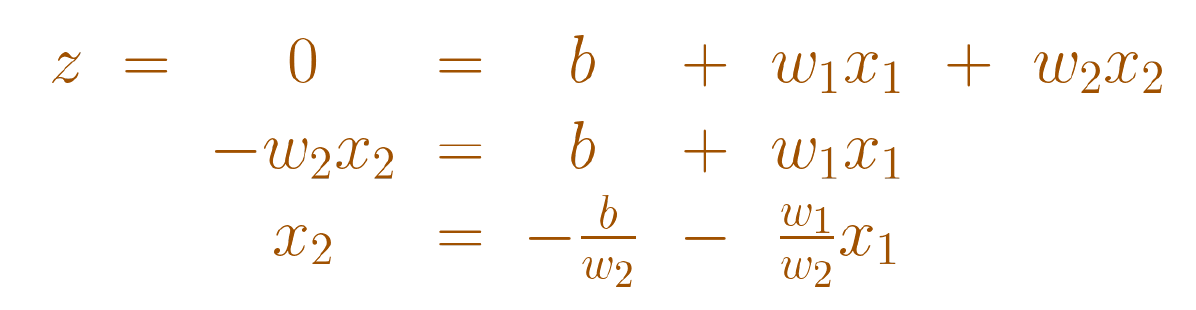

La figure ci-dessous contient  les positions des   données de training. C'est donc ce que le modèle "voit" lorsqu'il s'entraîne. Il tentera de séparer de son mieux les points  deux classes, représentée en rouge (classe négative)
et bleu (classe positive).

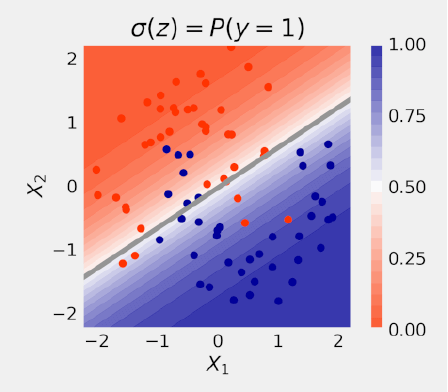

Dans le graphique les couleurs rouge signifient
les probabilités plus élevées (inférieures), et nous avons la frontière de décision sous la forme d'un ligne grise 
, correspondant à une probabilité de 50% (et une valeur logit de zéro).

Notre modèle a produit une ligne droite qui fait un assez bon travail en séparant les points rouges et les
points bleus. Ce n'était pas si difficile de toute façon, puisque les points bleus étaient
plus concentrés sur le coin inférieur droit, tandis que les points rouges étaient pour la plupart
dans le coin supérieur gauche. En d'autres termes, les classes étaient tout à fait séparables.

** Plus les points sont séparables plus la fonction perte est faible **





Maintenant, nous pouvons comprendre que la perte de validation est inférieure à la perte d'entraînement. Dans
l'ensemble de validation, les classes sont plus séparables que dans l'ensemble d'apprentissage. La decision boundary
 obtenue à l'aide de l'ensemble d'apprentissage peut faire un travail encore meilleur
séparant les points rouges et bleus. On peut le verifier à travers la courbe ci-dessous :

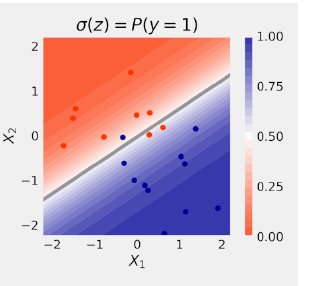

#### Etape de representation de la decision boundary
Il s'agit de faire des prédictions pour une grille de valeurs d'input. Une fois que nous avons la grille de prédictions, nous pouvons tracer les valeurs et leur étiquette de classe.
On utilisera un tracé de contour qui peut interpoler les couleurs entre les points.La fonction contourf() Matplotlib peut être utilisée.

In [34]:
# Definition les bornes de la grille
X_trans = sc.transform(X)
min1, max1 = X_trans[:,0].min() - 1, X_trans[:,0].max() + 1
min2, max2 = X_trans[:,1].min() - 1, X_trans[:,1].max() + 1

In [35]:
# definir les echelles au niveau des axes
x1grid = np.arange(min1, max1, 0.1)
x2grid = np.arange(min2, max2, 0.1)

In [36]:
# creer toutes les lignes et colonnes de la grille
xx, yy = np.meshgrid(x1grid, x2grid)

In [37]:
x2grid

array([-3.18973255, -3.08973255, -2.98973255, -2.88973255, -2.78973255,
       -2.68973255, -2.58973255, -2.48973255, -2.38973255, -2.28973255,
       -2.18973255, -2.08973255, -1.98973255, -1.88973255, -1.78973255,
       -1.68973255, -1.58973255, -1.48973255, -1.38973255, -1.28973255,
       -1.18973255, -1.08973255, -0.98973255, -0.88973255, -0.78973255,
       -0.68973255, -0.58973255, -0.48973255, -0.38973255, -0.28973255,
       -0.18973255, -0.08973255,  0.01026745,  0.11026745,  0.21026745,
        0.31026745,  0.41026745,  0.51026745,  0.61026745,  0.71026745,
        0.81026745,  0.91026745,  1.01026745,  1.11026745,  1.21026745,
        1.31026745,  1.41026745,  1.51026745,  1.61026745,  1.71026745,
        1.81026745,  1.91026745,  2.01026745,  2.11026745,  2.21026745,
        2.31026745,  2.41026745,  2.51026745,  2.61026745,  2.71026745,
        2.81026745,  2.91026745,  3.01026745,  3.11026745])

In [38]:
yy

array([[-3.18973255, -3.18973255, -3.18973255, ..., -3.18973255,
        -3.18973255, -3.18973255],
       [-3.08973255, -3.08973255, -3.08973255, ..., -3.08973255,
        -3.08973255, -3.08973255],
       [-2.98973255, -2.98973255, -2.98973255, ..., -2.98973255,
        -2.98973255, -2.98973255],
       ...,
       [ 2.91026745,  2.91026745,  2.91026745, ...,  2.91026745,
         2.91026745,  2.91026745],
       [ 3.01026745,  3.01026745,  3.01026745, ...,  3.01026745,
         3.01026745,  3.01026745],
       [ 3.11026745,  3.11026745,  3.11026745, ...,  3.11026745,
         3.11026745,  3.11026745]])

In [39]:
# Aplanir chaque partie en un seul vecteur pour les empiler et former des points pour prédire leurs classes
r1, r2 = xx.flatten(), yy.flatten()
r1, r2 = r1.reshape((len(r1), 1)), r2.reshape((len(r2), 1))

Ensuite, nous empilons les vecteurs côte à côte sous forme de colonnes dans un ensemble de données d'entrée, par ex. comme notre ensemble de données d'entraînement d'origine, mais à une résolution beaucoup plus élevée.

In [40]:
# horizontal stack vectors to create x1,x2 input for the model
grid = np.hstack((r1,r2))

In [41]:
# Faire de la prediction pour la grille
yhat = sbs.make_prediction(grid)

In [42]:
# Predire les probabilités
yhat_prob = torch.sigmoid(torch.as_tensor(yhat))

In [43]:
yhat_prob

tensor([[0.9139],
        [0.9227],
        [0.9307],
        ...,
        [0.0623],
        [0.0696],
        [0.0776]])

In [44]:
classes = (yhat >= 0).astype(int)


La fonction **contourf()** prend des grilles séparées pour chaque axe, tout comme ce qui a été renvoyé par notre appel précédent à meshgrid(). 
Nous pouvons donc utiliser xx et yy que nous avons préparés plus tôt et simplement remodeler les prédictions (classe) du modèle pour qu'elles aient la même forme.

In [45]:
classes = classes.reshape(xx.shape)

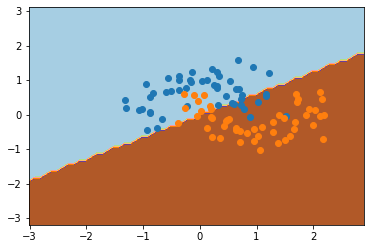

In [46]:
# Representer la grille comme une surface
from matplotlib import pyplot
pyplot.contourf(xx, yy, classes, cmap='Paired')
# creer un scatter plot pour chaque echantillon de chaque classe
for class_value in range(2):
    # Obtenir les index de lignes pour chaque echantillon de classe 
    row_ix = np.where(y == class_value)
    # creer un scatter pour les points
    plt.scatter(X[row_ix, 0], X[row_ix, 1], cmap='Paired')

On peut choisir de representer les probabilités au lieu des logits

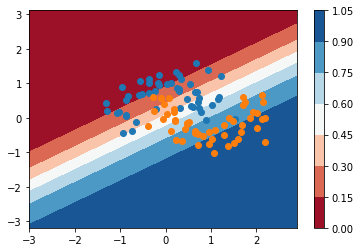

In [47]:
yhat_prob_num = yhat_prob.numpy()
yhat_prob_num = yhat_prob_num.reshape(xx.shape)
# plot the grid of x, y and z values as a surface
c = plt.contourf(xx, yy, yhat_prob_num, cmap='RdBu')
# add a legend, called a color bar
plt.colorbar(c)
# create scatter plot for samples from each class
for class_value in range(2):
    # get row indexes for samples with this class
    row_ix = np.where(y == class_value)
    # create scatter of these samples
    plt.scatter(X[row_ix, 0], X[row_ix, 1], cmap='Paired')

### Notion de separabilité

Est-il plus difficile de separer les données de la cellule ci-dessous que celles de la cellule d'aprés ?

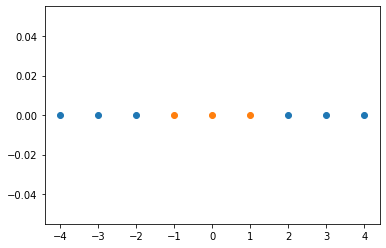

In [48]:
z = [-4,-3,-2,2,3,4]
t = [-1,0,1]



plt.scatter(z,np.zeros_like(z))
plt.scatter(t,np.zeros_like(t))

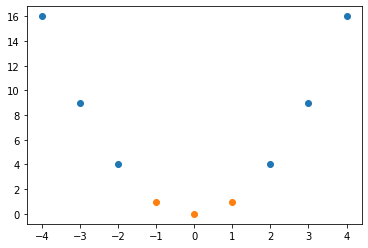

In [49]:
z = [-4,-3,-2,2,3,4]
t = [-1,0,1]
zsquared = [i**2 for i in z]
tsquared = [i**2 for i in t]


plt.scatter(z,zsquared)
plt.scatter(t,tsquared)

### Matrice de confusion

Une Confusion Matrix (matrice de confusion) ou tableau de contingence est un outil permettant de mesurer les performances d’un modèle de Machine Learning en vérifiant notamment à quelle fréquence ses prédictions sont exactes par rapport à la réalité dans des problèmes de classification.

Il présente  un résumé des résultats de prédictions sur un problème de classification. Les prédictions correctes et incorrectes sont mises en lumière et réparties par classe. Les résultats sont ainsi comparés avec les valeurs réelles.

Cette matrice permet de comprendre de quelle façon le modèle de classification est confus lorsqu’il effectue des prédictions. Ceci permet non seulement de savoir quelles sont les erreurs commises, mais surtout le type d’erreurs commises. Les utilisateurs peuvent les analyser pour déterminer quels résultats indiquent comment les erreurs sont commises.


Elle dépend entiérement du seuil utilisé. A chaque seuil sa matrice de confusion.


Il est composé de 4 quadrants: true negative (TN), false positive  (FP),false negative (FN) et true positive (TP).



In [50]:
y_val_pred = sbs.make_prediction(X_val)


In [51]:
prob_val = sigmoid(y_val_pred).squeeze()

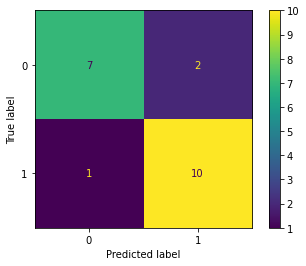

In [52]:
# Cette fonction est basé sur sklearn
cm_thresh50 = confusion_matrix(y_val, (prob_val >= 0.5))

# 1 false positive
# 2 false negative
disp = ConfusionMatrixDisplay(confusion_matrix=cm_thresh50)
disp.plot()

Ecrivons une fonction qui permet de decouper la matrice de confusion

In [53]:
def decoupageCM(cm):
  # Suivant la matrice de sklearn la premiére ligne contient les TN et FP
  negative_row = cm[0]
  TN = negative_row[0]
  FP = negative_row[1]

  # Suivant la matrice de sklearn la premiére ligne contient les FN et TP
  positive_row = cm[1]
  FN = positive_row[0]
  TP = positive_row[1]
  
  return TN,FP,FN,TP

In [54]:
tn,fp,fn,tp = decoupageCM(cm_thresh50)

In [55]:
print(tn)
print(fn)

7
1


#### Metriques

##### Taux de False et True positive

$$ Sensitivity = TPR =  \frac{TP}{TP + FN} $$ et $$ FPR = \frac{FP}{FP + TN}= 1 - \frac{TN}{FP + TN}  $$

Pour les deux, vous divisez une valeur sur la colonne de droite (positive) par la somme
de la ligne correspondante. Ainsi, le taux de vrais positifs est calculé en divisant la
valeur en bas à droite par la somme de la ligne du bas. De même, le taux
de faux positif est calculé en divisant la valeur en haut à droite par la somme des
rangée du haut.

**Bien, mais qu'est-ce qu'ils veulent dire?**

Le taux de vrais positifs vous indique combien de points de la classe positive,
votre modèle a prédit correctement. Dans notre exemple, nous savons qu'il y a 11 exemples positifs.
Notre modèle a obtenu dix bonnes réponses. Le TPR est de 10 sur 11, soit environ 91 %. Il y a encore
un autre nom pour cette métrique à savoir le **recall**. 

Le taux de faux positifs vous indique, combien de points de la classe négative 
votre modéle a prédit de maniére incorrecte. Dans notre exemple, nous savons qu'il y a neuf exempes de valeurs négatives. Notre modèle s'est trompé sur deux points. Le FPR est de 2 sur 9, soit environ 22 %.



In [56]:
# Cette fonction permet de calculer les deux taux

def tpr_fpr(cm):
  tn, fp, fn, tp = decoupageCM(cm)
  tpr = tp / (tp + fn)
  fpr = fp / (fp + tn)
  return tpr, fpr

In [57]:
tpr,fpr = tpr_fpr(cm_thresh50)
print(f"Taux de True Positive: {tpr}")
print(f"Taux de False Positive: {fpr}")

Taux de True Positive: 0.9090909090909091
Taux de False Positive: 0.2222222222222222


###### Compromis entre TPR et FPR

Comme toujours, il y a un compromis entre les deux métriques.
Disons que les faux négatifs sont mauvais pour notre application, et nous voulons améliorer
TRP. Voici une idée rapide : créons un modèle qui ne prédit que
la classe positive, en utilisant un seuil de zéro. Nous n'obtenons aucun faux négatif
que ce soit (parce qu'il n'y a pas de points négatifs en premier lieu). Notre TPR
est de 100 %. Génial, non ?

**Mauvais! Si tous les points sont prédits positifs, chaque exemple négatif sera
 un faux positif, et il n'y a pas de vrais négatifs. Notre FPR est également de 100 %. Le modèle est inutile.**


Et si les faux positifs étaient plutôt le problème ? Nous aimerions réduire
FPR. Une autre idée brillante me vient à l'esprit : faisons un modèle qui ne
prédit la classe négative, en utilisant un seuil de un. Nous n'obtenons pas de faux
positifs  (parce qu'il n'y a pas de points positifs en premier lieu).
Notre FPR est de 0 %. Mission accomplie, non ?

**Devine quoi? Encore faux! Si tous les points sont prédits négatifs, chaque
exemple positif sera un faux négatif, et il n'y a pas de vrais positifs.
Notre TPR est également à 0 %.**


##### La precision

$$ Precision = \frac{TP}{FP + TP}  $$

Nous la calculons dans la colonne de droite (positive) uniquement. Vous
divisez la valeur en bas à droite par la somme de la colonne de droite. Sa signification est
un peu complémentaire de celui du recall : combien de points classés comme positifs  votre modèle a prédit correctement. Dans notre exemple, le modèle a 
12 points positifs et a correctement classé dix points. La précision est de 10 sur 12, ou
environ 83 %.


In [58]:
# Cette fonction permet de claculer la precision et le recall
def precision_recall(cm):
  tn, fp, fn, tp = decoupageCM(cm)
  precision = tp / (tp + fp)
  recall = tp / (tp + fn)
  return precision, recall

In [59]:
prec,recall = precision_recall(cm_thresh50)
print(f"Precision: {prec}")
print(f"Recall: {recall}")

Precision: 0.8333333333333334
Recall: 0.9090909090909091


###### Compromis precision-recall


 Le compromis est un peu différent, cependant.
Disons que les faux négatifs sont mauvais pour notre application, et nous voulons  améliorer
le recall. Encore une fois, créons un modèle qui ne prédit que la classe positive,
en utilisant un seuil de zéro. Nous n'obtenons aucun faux négatif (parce que
il n'y a pas de points négatifs en premier lieu). Le recall est de 100 %. 

**Par contre si tous les points sont prédits positifs, chaque exemple négatif sera un
faux positif. La précision sera exactement la proportion d'échantillons positifs dans
l'ensemble de données.**


Et si les faux positifs étaient plutôt le problème ? 

Nous aimerions augmenter
précision. Il est temps de créer un modèle qui ne prédit que la classe négative en
en utilisant un seuil de un. Nous n'obtenons aucun faux positif (parce que
il n'y a pas de points positifs en premier lieu). Notre précision est de 100 %.

**Bien sûr, c'est trop beau pour être vrai… Si tous les points sont prédits
négatif, il n'y a pas de vrais positifs. Notre rappel est de 0 %.**


##### Accuracy
C'est le plus simple et le plus intuitif de tous : combien de fois votre modèle a-t-il
 correctement prédit, compte tenu de tous les points de données. Tout simple!

 $$ Accuracy = \frac{TP + TN}{FP + TP + FN + TN}  $$

 
 Dans notre exemple, le modèle a obtenu 17 points sur un total de 20 points de données. L'accuracy est de 85 %.  Plus l'accuracy est élevé sauf si vous disposez d'un ensemble de données déséquilibré.


Supposons que nous avons 1 000 points de données : 990 points sont négatifs, et seulement dix sont
positif. Maintenant, prenons un modèle qui utilise un seuil de un et prédit uniquement
la classe négative. De cette façon, nous obtenons  990 TN pour dix FN. L'accuracy de ce modèle est de 99 %. Mais le modèle est toujours inutile car
il n'obtiendra jamais un bon exemple positif.

**L'accuracy peut être trompeuse car elle n'implique pas de compromis avec un autre
métrique, comme les précédents.**

#### Le courbes: ROC et Precision-Recall

* La courbe ROC permet d'etudier le compromis entre TPR et FPR en faisant varier les seuils. Elle est une mesure de performance pour les problèmes de classification à différents réglages de seuil. ROC est une courbe de probabilité et AUC représente le degré ou la mesure de séparabilité. Il indique à quel point le modèle est capable de faire la distinction entre les classes. Plus l'AUC est élevée, plus le modèle prédit les classes 0 comme 0 et les classes 1 comme 1. Elle convient aux données équilibrées.
* La courbe Precision-Recall permet d'étudier le compromis entre Precision et Recall en faisant varier les seuils. Elle convient aux données déséquilibrées.

In [60]:
# Prenons un ensemble de seuil
threshs = np.linspace(0,1,11)

In [61]:
print(threshs)

[0.  0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9 1. ]


In [62]:
# Cette fonction est basé sur sklearn
precs = []
recs = []
tprs = []
fprs = []
for seuil in threshs:
  cm_thresh = confusion_matrix(y_val, (prob_val >= seuil))
  prec,rec = precision_recall(cm_thresh)
  tpr,fpr = tpr_fpr(cm_thresh)
  precs.append(prec)
  recs.append(rec)
  tprs.append(tpr)
  fprs.append(fpr)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in long_scalars
  after removing the cwd from sys.path.


Text(0.5, 1.0, 'Precision-Recall')

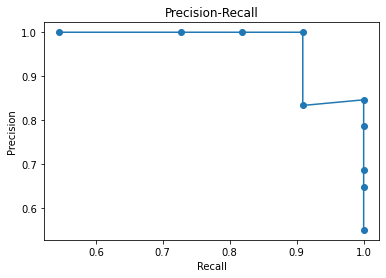

In [63]:
plt.plot(recs,precs,'o-')
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall")

Text(0.5, 1.0, 'Courbe ROC')

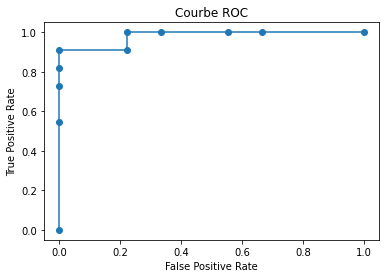

In [64]:
plt.plot(fprs,tprs,'o-')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Courbe ROC")

In [65]:
# Meme calcul avec scikit-learn
fpr, tpr, thresholds1 = roc_curve(y_val, prob_val )
prec, rec, thresholds2 = precision_recall_curve(y_val,prob_val)

* le seuil de zéro correspond au point le plus à droite des deux courbes
* le seuil de un correspond au point le plus à gauche des deux courbes
* le point le plus à droite de la courbe Precision-Recall représente la proportion d'exemples positifs dans le jeu de données
* Si le seuil augmente, on se déplace vers la gauche le long des deux courbes

In [66]:
# Aire sous la courbe
auroc = auc(fpr, tpr)
aupr = auc(rec, prec)
print(auroc, aupr)

0.9797979797979798 0.9854312354312356


## References

* https://machinelearningmastery.com/roc-curves-and-precision-recall-curves-for-classification-in-python/

* https://machinelearningmastery.com/roc-curves-and-precision-recall-curves-for-imbalanced-classification/
